# Setup

This project requires Python 3.7 or above

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn >= 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TenserFlow >= 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons

## The Perceptron

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)

In [7]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='perceptron', penalty=None, learning_rate='constant', eta0=1,
                        random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y=None, xlabel=None, ylabel=None):
    a = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_ / model.coef_[0, 1]
    axes = [0, 5, 0, 2]
    x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    y_pred = per_clf.predict(X_new)
    zz = y_pred.reshape(x0.shape)
    custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

    plt.figure(figsize=(7, 3))
    plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
    plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
    plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
            linewidth=3)
    plt.contourf(x0, x1, zz, cmap=custom_cmap)
    
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.legend(loc="lower right")
    plt.axis(axes)
    plt.show()

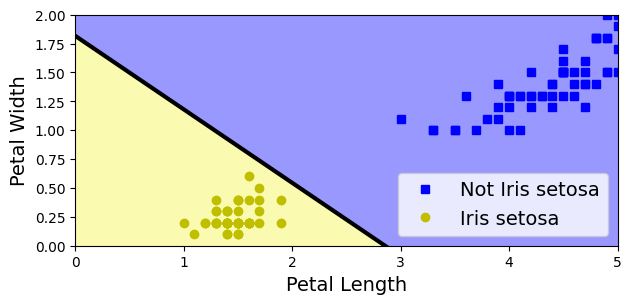

In [10]:
plot_decision_boundary(per_clf, X, y, 'Petal Length', 'Petal Width')

**Activation functions**

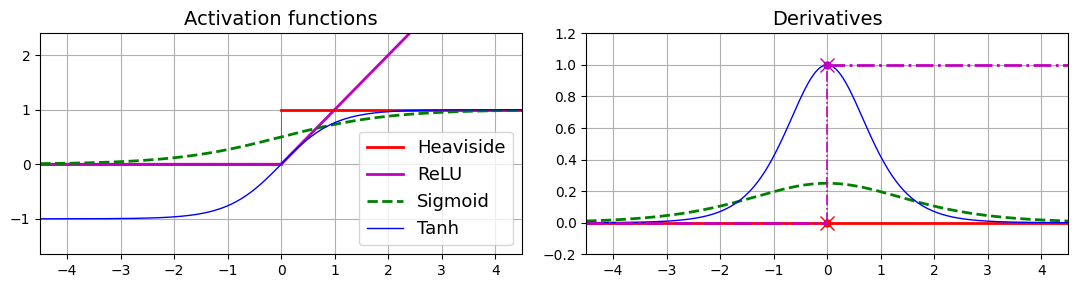

In [11]:
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## Regression MLPs

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, 
                                                              random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full,
                                                  random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

0.5053326657968725

## Classification MLPs

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras
## Building an Image Classifier using the Sequential API
### Using Keras to load the dataset

In [14]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_val, y_val = X_train_full[-5000:], y_train_full[-5000:]

In [15]:
X_train.shape

(55000, 28, 28)

In [16]:
X_train.dtype

dtype('uint8')

In [17]:
X_train, X_val, X_test = X_train / 255, X_val / 255, X_test / 255

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

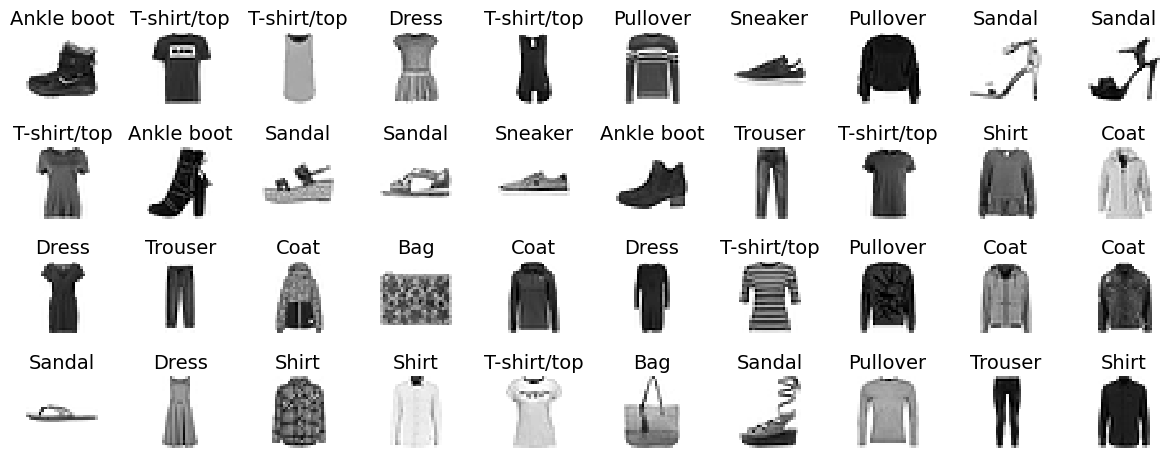

In [19]:
# extra code
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        idx = n_cols * row + col
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(X_train[idx], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[idx]])
    
plt.subplots_adjust(wspace=0.2, hspace=0.2)

save_fig('fashion_mnist_plot')
plt.show()

### Creating the model using the sequential API

In [20]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


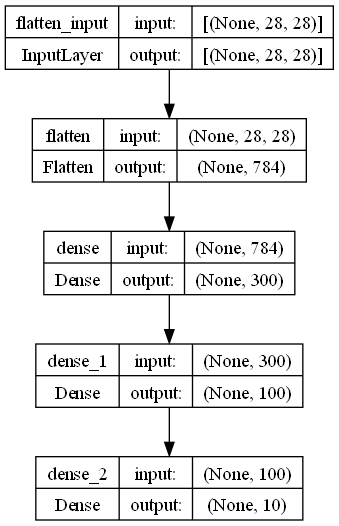

In [23]:
# another way to display the model's architecture
tf.keras.utils.plot_model(model, 'my_fashion_mnist_model.png', show_shapes=True)

In [24]:
model.layers

In [25]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [27]:
model.get_layer('dense') is hidden1

True

In [28]:
weights, biases = hidden1.get_weights()
weights

array([[-0.04053499, -0.03101544,  0.00970984, ...,  0.05382757,
        -0.0197125 ,  0.00537925],
       [ 0.012008  ,  0.05460443,  0.01754606, ..., -0.00469406,
        -0.02412103, -0.04885487],
       [-0.05354067, -0.01287146, -0.00175876, ..., -0.04997353,
        -0.04780556,  0.05511299],
       ...,
       [ 0.0146749 , -0.01728394, -0.00413821, ...,  0.06504875,
         0.00216961,  0.00041234],
       [ 0.07366988,  0.05139972, -0.06343851, ..., -0.02537097,
         0.06821947, -0.03643034],
       [-0.01455444,  0.02207595, -0.02908799, ...,  0.0290535 ,
        -0.04592744, -0.03684065]], dtype=float32)

In [29]:
weights.shape

(784, 300)

In [30]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [31]:
biases.shape

(300,)

### Compiling the model

In [32]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [36]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0], dtype=int64)

### Training and evaluating the model

In [33]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val))

Epoch 1/30
1719/1719 [==============================] - 10s 2ms/step - loss: 0.7233 - accuracy: 0.7594 - val_loss: 0.5036 - val_accuracy: 0.8278
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4892 - accuracy: 0.8299 - val_loss: 0.4648 - val_accuracy: 0.8336
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4437 - accuracy: 0.8431 - val_loss: 0.4231 - val_accuracy: 0.8532
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4187 - accuracy: 0.8529 - val_loss: 0.3975 - val_accuracy: 0.8598
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3979 - accuracy: 0.8598 - val_loss: 0.3957 - val_accuracy: 0.8600
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3814 - accuracy: 0.8646 - val_loss: 0.3925 - val_accuracy: 0.8566
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3692 - accuracy: 0.8689 - val_loss: 0.3744 - val_accuracy

In [34]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

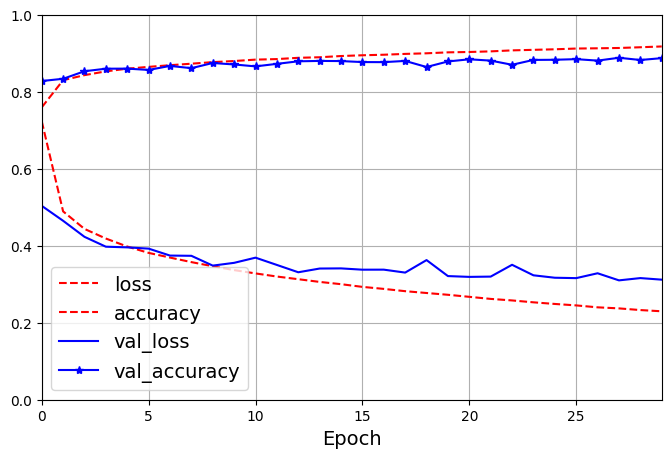

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*']
)
plt.legend(loc='lower left')
plt.show()

In [37]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3289 - accuracy: 0.8850


[0.3288804888725281, 0.8849999904632568]

### Using the model to make predictions

In [38]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 88ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [39]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [40]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [41]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

## Building a Regression MLP using the Sequential API